# HW - 3
## Q1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sn
import math
from scipy.linalg import hilbert
import sympy
%matplotlib inline
rcParams['figure.figsize'] = 8,8


NOISES =  [10e-7, 10e-8, 10e-9, 10e-10, 10e-11, 10e-12, 10e-13, 10e-14, 0]

def plot_on_complex_plane(data, title, title2):
    # extract real part using numpy array
    x = data.real
    # extract imaginary part using numpy array
    y = data.imag

    # plot the complex numbers
    fig, ax = plt.subplots()
    ax.plot(x, y, 'g*')
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    # ax.axis('equal')
    # grid()
    plt.xlim([0.8, 1.2])
    plt.ylim([-0.2, 0.2])
    plt.ylabel('Imaginary')
    plt.xlabel('Real')
    plt.title(title)
    plt.savefig(title2+'.png', dpi=150)
    return ax

def sliding_windows(a, W):
    a = np.asarray(a)
    p = np.zeros(W-1,dtype=a.dtype)
    b = np.concatenate((p,a,p))
    s = b.strides[0]
    strided = np.lib.stride_tricks.as_strided
    return strided(b[W-1:], shape=(W,len(a)+W-1), strides=(-s,s))




def question1_generate_matrix():
    a = [0,1]
    temp = sliding_windows(a, W=7)
    J = temp[:,:-1]
    I = np.identity(7)
    A = J+I
    return A

def question1_show_eigenvalues(A):
    for idx, noise in enumerate(NOISES):
        es = np.linalg.eigvals(A+noise)
        title = "Figure"+str(idx+1)+": "+str(NOISES[idx]) + " Noise"
        plot_on_complex_plane(es, title, "Figure"+str(idx+1))
    

In [2]:
A = question1_generate_matrix()

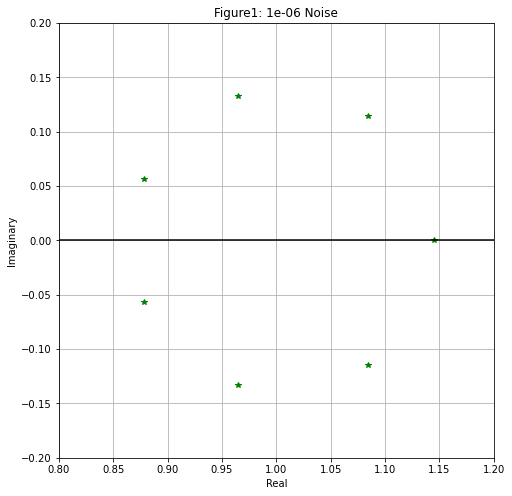

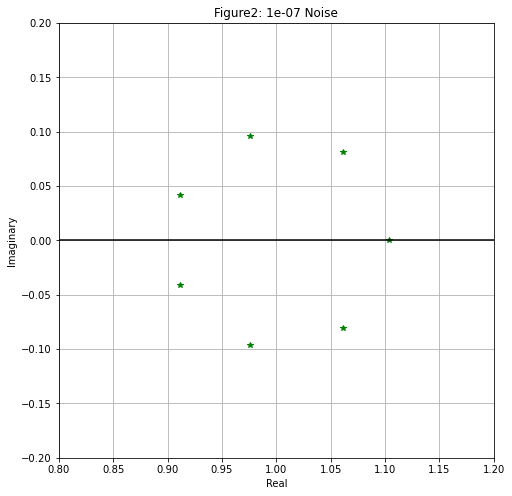

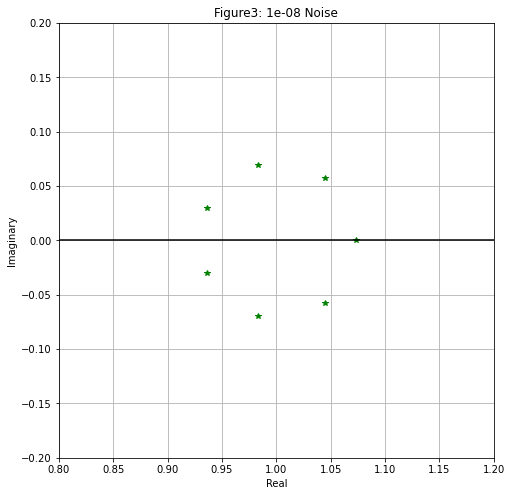

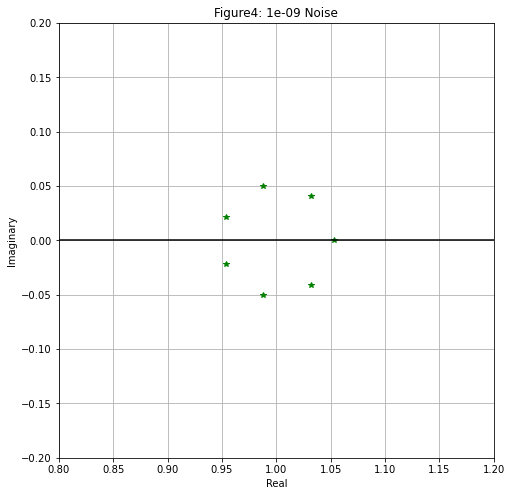

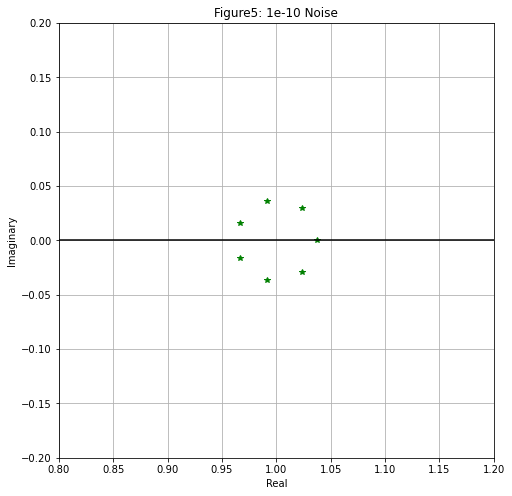

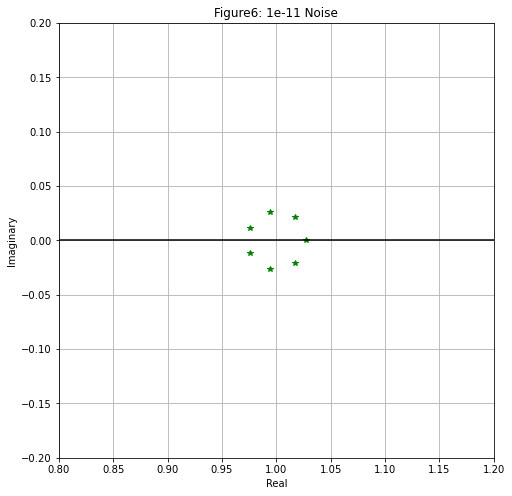

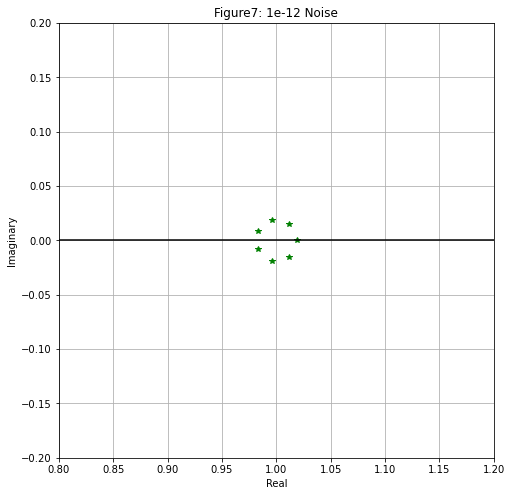

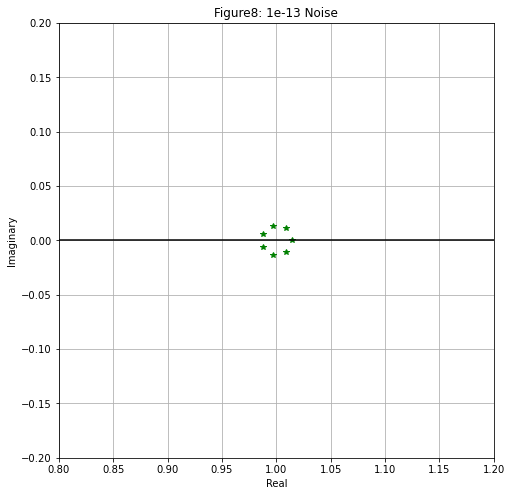

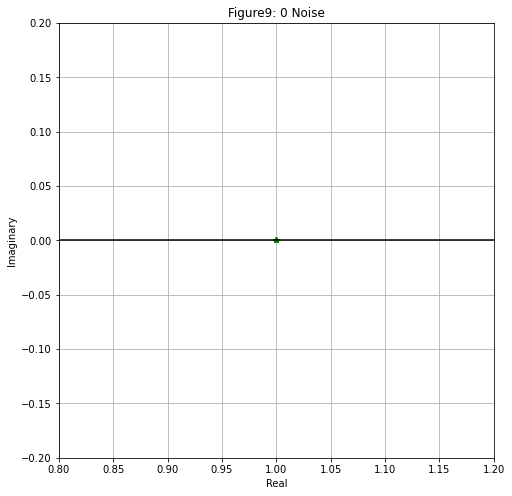

In [3]:
question1_show_eigenvalues(A)

# Q-2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sn
import math
from scipy.linalg import hilbert
import sympy

In [31]:
def hilbert_jacobi(n):
    iteration = 0
    H =hilbert(n)
    eigenvectors = np.identity(30)
    # w, v = np.linalg.eig(H)
    
    # For stopping criteria
    dia = np.diag_indices(n)
    def off(arr):        
        dia_sum = sum(np.square(arr[dia])) # sum of diagonal elements
        off_dia_sum = np.sum(np.square(arr)) - dia_sum
        return off_dia_sum
    
    
    while off(H) > 0.0005:        
        # Step 1: Obtain the highest off diagonal value's index
        masked_H = H.copy()
        for i in range(n):
            for j in range(i+1):
                masked_H[i,j] = 0
        ind = np.unravel_index(np.argmax(masked_H, axis=None), masked_H.shape)
        first_ind = ind[0]
        second_ind = ind[1]

        # Step 2: Find the angle, x
        sinx_ = H[first_ind,second_ind]
        msinx_ = H[second_ind,first_ind]
        cosx_1 = H[first_ind,first_ind]
        cosx_2 = H[second_ind,second_ind]
        x = 0.5*math.atan(2*sinx_/(cosx_1-cosx_2))

        # Step 3: Construct P
        P = np.identity(30)
        P[first_ind,second_ind]= math.sin(x)
        P[second_ind,first_ind] = (-1) * math.sin(x)
        P[first_ind,first_ind] = math.cos(x)
        P[second_ind,second_ind] = math.cos(x)

        # Step 4: Calculate H_hat
        H = P.T @ H @ P
        
        # Step 5: Calculate approximated eigens
        eigenvectors = eigenvectors @ P

        iteration += 1
        # print(iteration)
        # if iteration == 109166:            
        #     plt.figure(figsize=(15, 15))
        #     ax= sn.heatmap(data = H, cmap="YlGnBu",annot=True)
        #     ax.set_title('Iteration-'+str(iteration)+': H_hat')
    return H, eigenvectors

def normalize(x):
    fac = abs(x).max()
    x_n = x / x.max()
    return fac, x_n

def hilbert_power(n, iteration):
    v = np.ones((n,1))
    H =hilbert(n)
    for i in range(iteration):
        v = np.dot(H, v)
        e, v = normalize(v)
    return v, e

def compare_jacobi(H, H_hat):
    w, v = np.linalg.eig(H)
    w_hat, v_hat = np.linalg.eig(H_hat)
    error_in_eigenvalues = np.abs(w-w_hat)
    eigenvalues = np.stack((w, w_hat, error_in_eigenvalues), axis=1)
    df = pd.DataFrame(eigenvalues, columns=['Actual Eigenvalues', 'Approximated Eigenvalues', 'Abs Differences'])
    display(df)
    
    df = pd.DataFrame(v_hat)
    display(df)
    norms = []
    for i in range(30):
        norms.append(np.sum(np.power((v[:,i]-v_hat[:,i]),2)))
    df = pd.DataFrame(norms, columns=['L2 Norm Between Actual and Approximated'])
    display(df)
    
def compare_power(v,e, v_power, e_power):
    dom_ind = np.argmax(e)
    dom_lambda = e[dom_ind]
    error_in_eigenvalues = np.abs(dom_lambda-e_power)
    eigenvalues = np.stack((np.real(dom_lambda), e_power, error_in_eigenvalues),axis = 0).reshape((1,3))
    df = pd.DataFrame(eigenvalues, columns=['Actual Dominant Eigenvalue', 'Approximated Dominant Eigenvalue', 'Abs Difference'])
    display(df)
    
    dom_v = v[:,dom_ind]
    e_normalized, dom_v = normalize(dom_v)
    dom_v = dom_v/10
    error_in_eigenvectors = np.sum(np.power((dom_v-v_power),2))
    eigenvectors = np.stack((dom_v.reshape((30,1)), v_power), axis=1).reshape((30,2))
    df = pd.DataFrame(eigenvectors, columns=['Actual Dominant Eigenvector', 'Approximated Dominant Eigenvector'])
    display(df)
    
    df = pd.DataFrame(error_in_eigenvectors.reshape(1,1), columns=['L2 Norm Between Actual and Approximated'])
    display(df) 

In [49]:
w_hat, v_hat = np.linalg.eig(H_hat)
x,y =normalize(v_hat_calculated[:,0])
y*100

array([ 1.42722215e+00,  4.74122407e+01, -5.32937204e+01, -5.70657636e+01,
       -6.21621686e+01,  5.95248359e+01, -4.06533120e+01, -6.62510360e+01,
        8.54117037e+01,  4.74706586e+01,  5.40470671e+01,  7.97237347e+01,
        7.20808092e+01,  4.07478262e+01,  1.00000000e+02,  9.94893110e+01,
        3.54404493e+01,  5.51579461e+01, -2.97741646e+01, -7.38318727e+02,
        6.61217275e+01,  2.41631310e+01,  2.24853832e+01,  4.92082494e+01,
        7.68985896e+00,  5.37065076e+01,  2.19360252e+00,  4.30548436e-01,
        1.20219862e+00, -5.38700988e+00])

In [ ]:
v_hat_calculated[:,0]

array([ 1.80022225e-03,  5.98032833e-02, -6.72218694e-02, -7.19797245e-02,
       -7.84080592e-02,  7.50814677e-02, -5.12779295e-02, -8.35655394e-02,
        1.07733788e-01,  5.98769684e-02,  6.81721010e-02,  1.00559286e-01,
        9.09189059e-02,  5.13971446e-02,  1.26134691e-01,  1.25490535e-01,
        4.47027012e-02,  6.95733048e-02, -3.75555505e-02, -9.31276044e-01,
        8.34024366e-02,  3.04780906e-02,  2.83618686e-02,  6.20686733e-02,
        9.69957983e-03,  6.77425373e-02,  2.76689376e-03,  5.43070939e-04,
        1.51638951e-03, -6.79488826e-03])

In [41]:
x,y = normalize( v_hat_calculated)
y[:,0]

array([ 1.86783105e-03,  6.20492439e-02, -6.97464410e-02, -7.46829812e-02,
       -8.13527372e-02,  7.79012129e-02, -5.32037135e-02, -8.67039108e-02,
        1.11779818e-01,  6.21256963e-02,  7.07323594e-02,  1.04335872e-01,
        9.43334388e-02,  5.33274059e-02,  1.30871781e-01,  1.30203433e-01,
        4.63815473e-02,  7.21861865e-02, -3.89659795e-02, -9.66250868e-01,
        8.65346825e-02,  3.16227199e-02,  2.94270215e-02,  6.43997125e-02,
        1.00638554e-02,  7.02866630e-02,  2.87080669e-03,  5.63466406e-04,
        1.57333874e-03, -7.05007578e-03])

In [22]:
v_power

array([[1.        ],
       [0.64236484],
       [0.49574826],
       [0.41108497],
       [0.35443774],
       [0.31324928],
       [0.28164831],
       [0.25647235],
       [0.23584686],
       [0.2185808 ],
       [0.20387649],
       [0.191177  ],
       [0.18008025],
       [0.17028779],
       [0.16157291],
       [0.15375989],
       [0.14671023],
       [0.14031314],
       [0.13447877],
       [0.12913345],
       [0.12421613],
       [0.11967575],
       [0.11546923],
       [0.11155998],
       [0.10791665],
       [0.10451226],
       [0.10132343],
       [0.09832979],
       [0.09551351],
       [0.0928589 ]])

In [8]:
# n = 30
# H =hilbert(n)
# w, v = np.linalg.eig(H)
# H_hat, v_hat_calculated = hilbert_jacobi(n)


In [9]:
# compare_jacobi(H, H_hat)

,Actual Eigenvalues,Approximated Eigenvalues,Abs Differences
0,1.986493e+00+0.000000e+00j,1.986493e+00+0.000000e+00j,3.330669e-15+0.000000e+00j
1,5.725999e-01+0.000000e+00j,5.725999e-01+0.000000e+00j,1.088019e-14+0.000000e+00j
2,1.056456e-01+0.000000e+00j,1.056456e-01+0.000000e+00j,9.992007e-16+0.000000e+00j
3,1.548149e-02+0.000000e+00j,1.548149e-02+0.000000e+00j,3.729655e-16+0.000000e+00j
4,1.926621e-03+0.000000e+00j,1.926621e-03+0.000000e+00j,8.385220e-16+0.000000e+00j
5,2.087851e-04+0.000000e+00j,2.087851e-04+0.000000e+00j,9.131964e-16+0.000000e+00j
6,1.996575e-05+0.000000e+00j,1.996575e-05+0.000000e+00j,7.974917e-16+0.000000e+00j
7,1.698632e-06+0.000000e+00j,1.698632e-06+0.000000e+00j,5.728429e-16+0.000000e+00j
8,1.292563e-07+0.000000e+00j,1.292563e-07+0.000000e+00j,4.351556e-16+0.000000e+00j
9,8.828001e-09+0.000000e+00j,8.828002e-09+0.000000e+00j,1.035634e-15+0.000000e+00j


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.001975,0.004454,0.011255,0.058582,0.165334,-0.109993,0.168650,0.159383,0.015808,0.225165,...,-0.310572,-0.007799,-0.009831,-0.011657,-0.056474,-0.466401,0.108687,-0.322969,0.030705,0.113949
1,0.001223,0.003277,0.018328,-0.029383,-0.363169,0.380524,-0.136092,0.270704,-0.009040,0.210089,...,-0.030275,0.003297,-0.006513,0.011433,0.029219,0.064230,0.059465,0.035401,0.031635,0.061106
2,-0.999986,0.000345,0.000878,-0.001150,0.000464,-0.001210,0.000285,0.001396,0.000182,0.000162,...,-0.000623,-0.000020,0.000037,0.000814,-0.000036,-0.000391,0.000931,0.000819,0.002263,0.001046
3,-0.000382,0.002372,0.009009,-0.006646,0.185409,0.327762,0.176545,-0.534823,-0.173007,0.334608,...,0.075382,0.095953,-0.086343,-0.075340,-0.010694,0.018109,-0.040720,0.005881,-0.013390,-0.006634
4,-0.000420,-0.000138,0.002851,-0.015938,-0.220709,-0.020456,-0.059478,-0.163952,0.141258,0.025968,...,0.029039,-0.016588,0.006989,-0.004200,0.006037,-0.009291,0.009618,-0.014522,0.013091,-0.017491
5,0.000774,0.000520,0.998640,-0.024677,-0.002177,-0.002065,0.011241,-0.000071,-0.004119,-0.017719,...,-0.003845,0.001611,0.000103,-0.017070,-0.016476,0.004859,0.002447,-0.006757,-0.007881,-0.009789
6,0.002269,0.002510,0.018041,0.012140,0.094102,-0.170055,0.113313,-0.017165,0.175980,0.188569,...,0.082069,-0.031910,0.045390,0.014243,0.248566,-0.113824,0.062882,0.573512,0.631418,0.026477
7,-0.000036,0.001637,0.014607,0.091100,0.241146,0.172640,-0.177336,-0.097920,0.041990,-0.084316,...,0.324912,-0.537416,0.521494,0.539927,0.088910,0.025290,-0.266554,-0.002292,-0.020447,0.128339
8,0.000882,-0.000012,0.008372,-0.003015,0.256036,-0.034239,0.094789,0.183501,-0.137275,0.040834,...,-0.081703,0.164549,0.094084,0.389349,-0.045708,0.205096,-0.131268,0.248847,-0.141516,-0.076035
9,0.000667,0.002300,0.017956,0.394577,0.108878,-0.058494,-0.470216,0.236521,0.374537,-0.202965,...,0.053473,0.134751,-0.123393,-0.104562,-0.004875,0.019849,-0.059223,0.009050,0.023642,-0.007660


,L2 Norm Between Actual and Approximated
0,1.399870+0.000000j
1,2.310535+0.000000j
2,2.317838+0.000000j
3,2.048462+0.000000j
4,1.663564+0.000000j
5,2.328620+0.000000j
6,1.802179+0.000000j
7,2.282599+0.000000j
8,2.167126+0.000000j
9,2.507545+0.000000j


In [32]:
# v_power, e_power = hilbert_power(n, 10000000)
compare_power(v, w, v_power, e_power)


,Actual Dominant Eigenvalue,Approximated Dominant Eigenvalue,Abs Difference
0,1.986493,1.986493,1.776357e-15


,Actual Dominant Eigenvector,Approximated Dominant Eigenvector
0,1.076903-0.000000j,1.000000+0.000000j
1,0.691764-0.000000j,0.642365+0.000000j
2,0.533873-0.000000j,0.495748+0.000000j
3,0.442699-0.000000j,0.411085+0.000000j
4,0.381695-0.000000j,0.354438+0.000000j
5,0.337339-0.000000j,0.313249+0.000000j
6,0.303308-0.000000j,0.281648+0.000000j
7,0.276196-0.000000j,0.256472+0.000000j
8,0.253984-0.000000j,0.235847+0.000000j
9,0.235390-0.000000j,0.218581+0.000000j


,L2 Norm Between Actual and Approximated
0,71.375025+0.000000j


In [129]:
n = 30
H_hat, eigenvectors = hilbert_jacobi(30)

# Q-3

In [ ]:
def modified_sliding_windows(a, W):
    a = np.asarray(a)
    p = np.ones(W-1,dtype=a.dtype)
    b = np.concatenate((p,a,p))
    s = b.strides[0]
    strided = np.lib.stride_tricks.as_strided
    return strided(b[W-1:], shape=(W,len(a)+W-1), strides=(-s,s))

In [ ]:
a = [4]
B = modified_sliding_windows(a, W = 4)
es = np.linalg.eigvals(B)
w, v = np.linalg.eig(B)

In [ ]:
B

In [ ]:
D, P = np.linalg.eig(B)
D = np.diag(D)
k = 1
B_check= np.real(P @ D ** k @ np.linalg.inv(P))

In [ ]:
B_check

# Q-5

In [ ]:
a = [4]
B = modified_sliding_windows(a, W = 3)
es = np.linalg.eigvals(B)
w, v = np.linalg.eig(B)

In [ ]:
B

In [ ]:
w

In [ ]:
C = B.T @B
w, v = np.linalg.eig(C)
w

In [ ]:
other = np.identity(3)*9
other

In [ ]:
D = C+other
D

In [ ]:
w, v = np.linalg.eig(D)
w

In [ ]:
D_inv = np.linalg.inv(D)

In [ ]:
w, v = np.linalg.eig(D_inv)
w

In [ ]:
1/w[1]